# Pre-Post colonoscopy analysis of paired samples

I investigated whether there is any affect of colonoscopy on methylation levels and HMFC model scores using a set of 91 pairs of samples
half of which were taken pre colonoscopy and the other half of which were post-colonocopy. We hypothesize that there may be some bias in our data collected to date because most of our helathy samples in DC1 and DC2 were collected pre-colonoscopy and most of our CRC samples were collected post-colonoscopy. Here we investigate the effects of colonoscopy on paired samples to see if model scores are affected. 

In [271]:
import pandas as pd
from pineapple.contrib.components.data_factories.matrix_factory import MatrixFactory as mf
from pineapple.core import experiment_context
import datetime
experiment_context.reset_context(0, "x", "x", datetime.datetime(2020, 9, 30,0,0))
import featureio
import pickle
import numpy as np
from calzone import Calzone
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [215]:
# get sample ids from master sheet
master_data = pd.read_csv("./CRC Discovery 1 and 2 - Summary Counts - DC1+2 sample list (Master).csv")
master_data.head()

,Study,WGS Processing Batch,Sample ID,Sample Secondary ID,Patient ID,Patient Secondary ID,Patient Duplicates,Discovery Study,Pre/Post Study,PON,Discovery Analysis Batch,Pre/Post Analysis Batch,Notes,WGS Processing Batch.1,Olink Processing Batch,CDI Processing Batch,Methyl Processing Batch
0,DC1,DC1_BG1_WGS_2,13665,102103-post,17763,102103,NaN,Y,N,NaN,DC1,NaN,NaN,DC1 PB2,DC1 PB2,DC1 PB3,NaN
1,DC1,DC1_BG1_WGS_1,14479,102105-post,18731,102105,NaN,Y,N,NaN,DC1,NaN,NaN,DC1 PB1,DC1 PB1,DC1 PB2,NaN
2,DC1,DC1_BG1_WGS_1,13282,102214-post,17547,102214,NaN,Y,N,NaN,DC1,NaN,NaN,DC1 PB1,DC1 PB1,DC1 PB2,DC1 PB1
3,DC1,DC1_BG1_WGS_1,13666,102240-pre,17745,102240,NaN,Y,N,NaN,DC1,NaN,NaN,DC1 PB1,DC1 PB1,DC1 PB1,NaN
4,DC1,DC1_BG1_WGS_1,13667,102241-pre,17750,102241,NaN,Y,N,NaN,DC1,NaN,NaN,DC1 PB1,DC1 PB1,DC1 PB1,DC1 PB2


In [399]:
pre_post_data = master_data[master_data["Pre/Post Study"]=="Y"]
pre_post_sids = set(pre_post_data["Sample ID"].values)
pre_post_pids = set(pre_post_data["Patient ID"].values)

len(pre_post_sids)

228

In [317]:
#import M1 dsids
df_M1_dsids = pd.read_csv("./M1_lims_qc_ingestion.csv")
df_M1_dsids.head()
df_M1_dsids.shape

(1104, 5)

In [318]:
#omit qc failed samples
df_M1_dsids = df_M1_dsids[df_M1_dsids["manual_passed"]==True]
df_M1_dsids.shape

(1072, 5)

In [319]:
# match M1 dsids with sample ids
metadata = Calzone.get_dataset_metadata_with_ids(df_M1_dsids["sample_dataset_id"].tolist())

Missed Redis cache for 893 datasets with timestamp 2020-10-20 12:59:57.103778+00:00, reading from BigQuery instead


In [320]:
sids = [metadata[i].raw_dataset_metadata["dataset"]["sample_id"] for i in range(len(metadata))]

In [321]:
len(sids)

1072

In [322]:
dsid_dict = dict(zip(sids, df_M1_dsids["sample_dataset_id"].tolist()))

In [323]:
pre_post_dsids = []
for sid in pre_post_sids:
    if sid in dsid_dict.keys():
        pre_post_dsids.append(dsid_dict[sid])

In [324]:
with open("pre_post_dsids.csv","w") as fout:
    pd.DataFrame(pre_post_dsids).to_csv(fout, header=None, index=False)

In [ ]:
# create and summarize a training class containing all the paired samples. 
with featureio.FeatureIO() as ftio:
    print(ftio.create_training_class(training_class_name="colorectal_healthy_temseqV4_paired_pre_post_colonoscopy_v2", 
        desc="M1 paired pre/post colonoscopy samples, minus failed QCs", 
        datasets=pre_post_dsids))

In [326]:
mat_pre_post = mf.create_from_dataset_ids(pre_post_dsids, feature_str="hmcfc_methyl_v4_automatic_regions_20200914/v2")

Text(0, 0.5, 'number of samples')

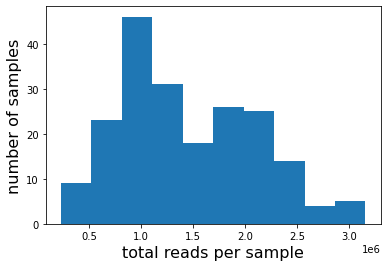

In [333]:
sums = mat_pre_post.x[...,3,1].sum(axis=1)
plt.hist(sums)
plt.xlabel("total reads per sample", size=16)
plt.ylabel("number of samples", size=16)

Some samples have low coverage, around 200,000 reads total. These samples still passed QC so we will leave them in. 

In [334]:
from collections import Counter
class_labels = [x.raw_sample_metadata["lims_top_diagnosis"]["cancer_type"] for x in mat_pre_post.sample_metadata]
Counter(class_labels)

Counter({'Colorectal Benign': 31,
         'Colorectal Pre-Cancer': 33,
         'Colorectal Normal / Healthy': 57,
         'Unclassifiable': 80})

In [401]:
# separate pre and post dsids
keep = [x.raw_sample_metadata["lims_sample"]["blood_draw_relative_to_tx"]=="Pre-Colonoscopy" for x in mat_pre_post.sample_metadata]
mat_pre = mat_pre_post[keep]
pre_dsids = [x.dataset.id for x in mat_pre.row_metadata]
#print(pre_dsids)

keep = [x.raw_sample_metadata["lims_sample"]["blood_draw_relative_to_tx"]=="Post-Colonoscopy" for x in mat_pre_post.sample_metadata]
mat_post = mat_pre_post[keep]
post_dsids = [x.dataset.id for x in mat_post.row_metadata]
#print(post_dsids)

In [402]:
print(len(post_dsids)) #103
print(len(pre_dsids)) #98

103
98


In [338]:
# create sample pre/post pairs

from collections import defaultdict
patient_dict = defaultdict(dict)
pids_post = [x.raw_sample_metadata["lims_patient"]["secondary_id"] for x in mat_post.sample_metadata]
pids_post_dict = dict(zip(pids_post, mat_post.sample_ids))
pids_pre = [x.raw_sample_metadata["lims_patient"]["secondary_id"] for x in mat_pre.sample_metadata]
pids_pre_dict = dict(zip(pids_pre, mat_pre.sample_ids))

for pid in (pids_post + pids_pre):
    if pid in pids_pre_dict.keys() and pid in pids_post_dict.keys():
        patient_dict[pid] = {"pre":pids_pre_dict[pid], "post":pids_post_dict[pid]}

In [403]:
len(patient_dict)

91

Some pairs are missing one of the samples in the data. Counting all properly paired samples by patient ID there are 91 of the original 114.
Most samples are Unclassifiable and none are CRC samples. Sample type is not the same annotation for pre and post blood draws for some pairs.

In [361]:
import pickle
with open("Pre_post_sample_dictionary.pkl", "wb") as fout:
    pickle.dump(patient_dict, fout)


In [407]:
keep = [x.raw_sample_metadata["lims_patient"]["secondary_id"] in patient_dict.keys() for x in mat_pre_post.sample_metadata ]
mat_pre_post_paired = mat_pre_post[keep]
types = [x.raw_sample_metadata["lims_top_diagnosis"]["cancer_type"] for x in mat_pre_post_paired.sample_metadata]

Counter(types)

Counter({'Colorectal Benign': 29,
         'Colorectal Pre-Cancer': 31,
         'Colorectal Normal / Healthy': 49,
         'Unclassifiable': 73})

## Model scores

I trained a model on all M1 (DC2) samples that did not overlap with the paired samples. The noise floor was set to 2e05 and other parameters were set to default. I then ran inference on all the paired samples using the model. 

In [340]:
from pineapple.contrib.results.inference_loader import InferenceResultWithMetadataLoader
bucket = "freenome-user-data-bgould"
path = "pre_post_crc/pre_post_crc/hmcfc_methyl_v4_automatic_regions_20200914_CRC_vs_Healthy_2e05/fold_pred_voting"
inference_predictions = InferenceResultWithMetadataLoader(bucket=bucket, path=path).load_result_dataframe()

In [100]:
list(inference_predictions.columns)

['sample_metadata.sex',
 'sample_metadata.age_at_blood_draw',
 'sample_metadata.site_name',
 'sample_metadata.ethnicity_simple',
 'sample_metadata.fit_result',
 'sample_metadata.stage',
 'sample_metadata.lesion_location',
 'sample_metadata.tumor_size_mm',
 'sample_metadata.num_adenomas',
 'sample_metadata.cancer_type',
 'sample_metadata.pathologic_type',
 'sample_metadata.pathologic_sub_type',
 'sample_metadata.tnm_t_tumor_extent',
 'sample_metadata.tnm_n_lymph_node_pos',
 'sample_metadata.tnm_m_distant_metastases',
 'sample_metadata.blood_draw_relative_to_tx',
 'sample_metadata.secondary_id',
 'sample_metadata.subj_hist_diverticular',
 'sample_metadata.subj_hist_cirrhosis',
 'sample_metadata.subj_hist_celiac',
 'sample_metadata.subj_hist_experi_enroll',
 'sample_metadata.subj_hist_experi_detail',
 'sample_metadata.subj_hist_week_days_active',
 'sample_metadata.subj_hist_day_mins_active',
 'sample_metadata.subj_hist_night_hours_sleep',
 'sample_metadata.subj_hist_worry',
 'sample_metadata.subj_hist_day_bms',
 'sample_metadata.subst_use_tobacco',
 'sample_metadata.subst_use_tobacco_quit_date',
 'sample_metadata.subst_use_tobacco_amount',
 'sample_metadata.subst_use_tobacco_years',
 'sample_metadata.subst_use_alcohol',
 'sample_metadata.subst_use_alcohol_quit_date',
 'sample_metadata.subst_use_alcohol_amount',
 'sample_metadata.subst_use_illicit_drug',
 'sample_metadata.subst_use_illicit_drug_quit_date',
 'sample_metadata.subst_use_illicit_drug_amount',
 'sample_metadata.colnosc_eval_full',
 'sample_metadata.colnosc_eval_left',
 'sample_metadata.colnosc_eval_trans',
 'sample_metadata.colnosc_eval_right',
 'sample_metadata.colnosc_elapsed_time',
 'sample_metadata.colnosc_histol_alter',
 'sample_metadata.colnosc_total_lesions',
 'sample_metadata.histol_pathog_init',
 'sample_metadata.hd_singular_confounder_fit_result',
 'sample_metadata.hd_colonoscopy_findings',
 'sample_metadata.hd_blood_sampling',
 'sample_metadata.hd_medical_history',
 'sample_metadata.hd_concomitant_medications',
 'sample_metadata.hd_protocol_deviation',
 'sample_metadata.hd_adenomatous_polyps',
 'sample_metadata.hd_hyperplastic_polyps',
 'sample_metadata.hd_colorectal_cancer',
 'sample_metadata.bmi',
 'olink_targeted_panel.study_num',
 'scrubbed_flowcells',
 'quiche_metadata.wgs_metrics_mean_coverage',
 'quiche_metadata.gcbias_summary_unique_gc_dropout',
 'quiche_metadata.gcbias_summary_unique_at_dropout',
 'quiche_metadata.estimated_library_size',
 'quiche_metadata.hs_metrics_mean_target_coverage',
 'quiche_metadata.methylation_coverage_metrics_conversion_rate',
 'sample_id',
 'score',
 'dataset_id_hmcfc_methyl_v4_automatic_regions_20200914/v2',
 'prediction',
 'y']

In [ ]:
inference_predictions["sample"]

In [341]:
np.isnan(inference_predictions["score"]).sum()

0

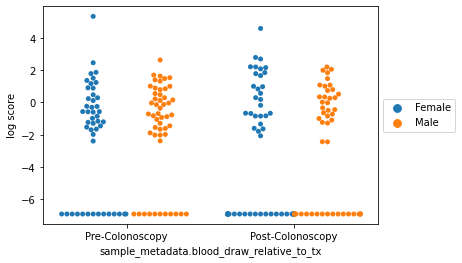

In [386]:
# compare model scores by sex
g = sns.swarmplot(x=inference_predictions["sample_metadata.blood_draw_relative_to_tx"], 
                y=np.log(inference_predictions["score"]+0.001), 
                hue=inference_predictions["sample_metadata.sex"],
                 dodge=True)
g.set_ylabel("log score")
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

In [383]:
from scipy.stats import wilcoxon
def run_wilcoxon(column, subtype):
    diffs=[]
    inference_predictions_subtype = inference_predictions[inference_predictions[column]==subtype]
    for pid in patient_dict.keys():
        if patient_dict[pid]["pre"] in inference_predictions_subtype["sample_id"].values:
            pre = inference_predictions_subtype.loc[inference_predictions_subtype["sample_id"]==patient_dict[pid]["pre"], "score"].values
            post = inference_predictions_subtype.loc[inference_predictions_subtype["sample_id"]==patient_dict[pid]["post"], "score"].values
            #print(pre)
            #print(post)
            if pre and post:
                diffs.append(float(pre-post))
    
    print(f"{subtype}: {wilcoxon(diffs)}")
    return 
            
run_wilcoxon("sample_metadata.sex", "Male")            

run_wilcoxon("sample_metadata.sex", "Female")

Male: WilcoxonResult(statistic=135.0, pvalue=0.9272980307084063)
Female: WilcoxonResult(statistic=99.0, pvalue=0.8227604017844778)


There is no statistically significant difference between pre and post colonoscopy model scores for males or females. 

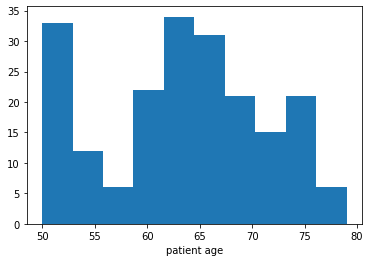

In [405]:
# compare model scores by age
plt.hist(inference_predictions["sample_metadata.age_at_blood_draw"])
plt.xlabel("patient age")
age_bin = []
for i,row in inference_predictions.iterrows():
    age = row["sample_metadata.age_at_blood_draw"]
    if age <= 55:
        age_bin.append("50-55")
    elif 55 < age <= 60:
        age_bin.append("55-60")
    elif 60 < age <= 65:
        age_bin.append("60-65")
    elif 65 < age <= 70:
        age_bin.append("65-70")
    elif 70 < age <= 75:
        age_bin.append("70-75")
    elif 75 < age < 80:
        age_bin.append(">75")
        
inference_predictions["age_bin"] = age_bin

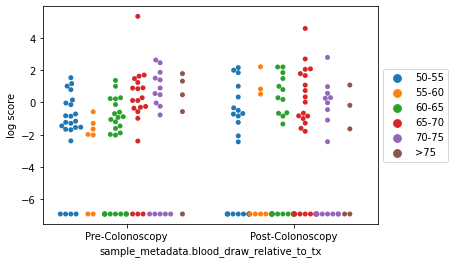

In [390]:
g= sns.swarmplot(x=inference_predictions["sample_metadata.blood_draw_relative_to_tx"], 
                y=np.log(inference_predictions["score"]+0.001), 
                hue=inference_predictions["age_bin"], dodge=True,
                hue_order = ["50-55","55-60","60-65","65-70","70-75",">75"]
                )
g.set_ylabel("log score")
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)


In [384]:
run_wilcoxon("age_bin", "50-55")
run_wilcoxon("age_bin", "55-60")
run_wilcoxon("age_bin", "60-65")
run_wilcoxon("age_bin", "65-70")
run_wilcoxon("age_bin", "70-75")
run_wilcoxon("age_bin", ">75")

50-55: WilcoxonResult(statistic=24.0, pvalue=0.7212766990291557)
55-60: WilcoxonResult(statistic=0.0, pvalue=0.17971249487899976)
60-65: WilcoxonResult(statistic=4.0, pvalue=0.0499499764547464)
65-70: WilcoxonResult(statistic=33.0, pvalue=0.6378701798979456)
70-75: WilcoxonResult(statistic=8.0, pvalue=0.16142946236708333)
75-80: WilcoxonResult(statistic=1.0, pvalue=0.28504940740261275)


There are no statistically significant differences between pre- and post- colonoscopy samples for any age bin. 

Text(0, 0.5, 'log score')

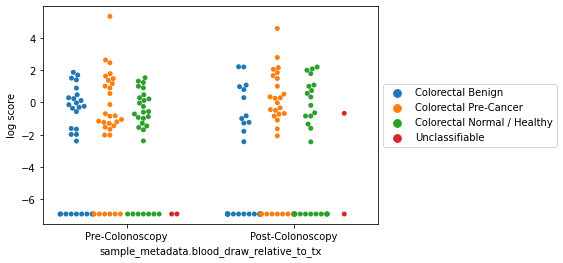

In [414]:
# examine score differences by diagnosis using pre-colonoscopy diagnoses (which have the fewest unclassifiable samples)
types = [x.raw_sample_metadata["lims_top_diagnosis"]["cancer_type"] for x in mat_pre_post.sample_metadata]
sid_to_type = dict(zip(mat_pre_post.sample_ids, types))

sid_to_type2 = {}
for p,v in patient_dict.items():
    sid_to_type2[v["pre"]]= sid_to_type[v["pre"]]
    sid_to_type2[v["post"]]= sid_to_type[v["pre"]]

pre_post_paired_sids = []
for p,v in patient_dict.items():
    pre_post_paired_sids.append(v["pre"])
    pre_post_paired_sids.append(v["post"])

keep = [sid in pre_post_paired_sids for sid in inference_predictions["sample_id"]]
inference_predictions_paired = inference_predictions[keep]
inference_predictions_paired["diagnosis"] = [ sid_to_type2[sid] for sid in inference_predictions_paired["sample_id"]]

g= sns.swarmplot(x=inference_predictions_paired["sample_metadata.blood_draw_relative_to_tx"], 
                y=np.log(inference_predictions_paired["score"]+0.001), 
                hue=inference_predictions_paired["diagnosis"], dodge=True)
g.legend(loc="center left", bbox_to_anchor=(1.0,0.5), ncol=1)
plt.ylabel("log score")

In [417]:
def run_wilcoxon2(column, subtype):
    diffs=[]
    inference_predictions_subtype = inference_predictions_paired[inference_predictions_paired[column]==subtype]
    for pid in patient_dict.keys():
        if patient_dict[pid]["pre"] in inference_predictions_subtype["sample_id"].values:
            pre = inference_predictions_subtype.loc[inference_predictions_subtype["sample_id"]==patient_dict[pid]["pre"], "score"].values
            post = inference_predictions_subtype.loc[inference_predictions_subtype["sample_id"]==patient_dict[pid]["post"], "score"].values
            #print(pre)
            #print(post)
            if pre and post:
                diffs.append(float(pre-post))
    
    print(f"{subtype}: {wilcoxon(diffs)}")
    return 


run_wilcoxon2("diagnosis","Colorectal Benign")
run_wilcoxon2("diagnosis", "Colorectal Pre-Cancer")
run_wilcoxon2("diagnosis","Colorectal Normal / Healthy")
#run_wilcoxon2("diagnosis", "Unclassifiable")

Colorectal Benign: WilcoxonResult(statistic=19.0, pvalue=0.3862707203664827)
Colorectal Pre-Cancer: WilcoxonResult(statistic=105.0, pvalue=1.0)
Colorectal Normal / Healthy: WilcoxonResult(statistic=29.0, pvalue=0.24886387493792206)


There is no significant difference between pre and post samples for any sample type. This negates the hypothesis that AAs might be different because they are resected during a colonoscopy. 

SpearmanrResult(correlation=0.38473744653300496, pvalue=0.00016624983267039584)

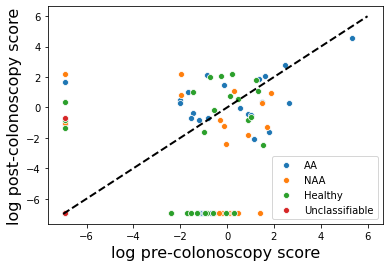

In [345]:
# explore the correlation between pre and post colonoscopy model scores
patients = patient_dict.keys()
pre_scores = [float(inference_predictions.loc[inference_predictions["sample_id"]==patient_dict[pid]["pre"], "score"].values+0.001) for pid in patients]
post_scores = [float(inference_predictions.loc[inference_predictions["sample_id"]==patient_dict[pid]["post"], "score"].values + 0.001) for pid in patients]

aas = [bool(inference_predictions.loc[inference_predictions["sample_id"]==patient_dict[pid]["pre"], "sample_metadata.cancer_type"].values=="Colorectal Pre-Cancer") for pid in patients]
pre_scores_aa = np.array(pre_scores)[aas]
post_scores_aa = np.array(post_scores)[aas]
naas = [bool(inference_predictions.loc[inference_predictions["sample_id"]==patient_dict[pid]["pre"], "sample_metadata.cancer_type"].values=="Colorectal Benign") for pid in patients]
pre_scores_naa = np.array(pre_scores)[naas]
post_scores_naa = np.array(post_scores)[naas]
healthy = [bool(inference_predictions.loc[inference_predictions["sample_id"]==patient_dict[pid]["pre"], "sample_metadata.cancer_type"].values=="Colorectal Normal / Healthy") for pid in patients]
pre_scores_healthy = np.array(pre_scores)[healthy]
post_scores_healthy = np.array(post_scores)[healthy]
uncl = [bool(inference_predictions.loc[inference_predictions["sample_id"]==patient_dict[pid]["pre"], "sample_metadata.cancer_type"].values=="Unclassifiable") for pid in patients]
pre_scores_uncl = np.array(pre_scores)[uncl]
post_scores_uncl = np.array(post_scores)[uncl]

#print(pre_scores)
g = sns.scatterplot(np.log(pre_scores_aa), np.log(post_scores_aa), label="AA")
sns.scatterplot(np.log(pre_scores_naa), np.log(post_scores_naa), label="NAA")
sns.scatterplot(np.log(pre_scores_healthy), np.log(post_scores_healthy), label="Healthy")
sns.scatterplot(np.log(pre_scores_uncl), np.log(post_scores_uncl), label="Unclassifiable")
plt.legend()
g.set_ylabel("log post-colonoscopy score",size=16)
g.set_xlabel("log pre-colonoscopy score", size=16)

plt.plot([-7, 6], [-7, 6], linewidth=2, linestyle="--", color="k")

from scipy.stats import spearmanr
spearmanr(pre_scores, post_scores)

Pre and post colonoscopy model scores are weakly but significantly correlated at r=0.38.

Text(0.5, 0, 'log model score')

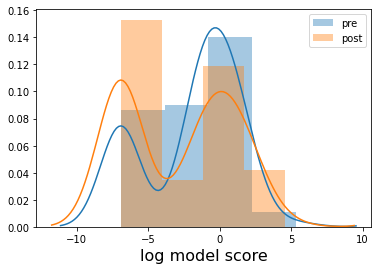

In [347]:
#histogram of pre scores histogram of post scores. 
sns.distplot(np.log(pre_scores), label='pre')
sns.distplot(np.log(post_scores), label='post')
plt.legend()
plt.xlabel("log model score", size=16)

In [348]:
# see how model scores change with time between pre and post blood draws. 
coll_dates = [x.raw_sample_metadata["lims_sample"]["collection_date"] for x in mat_pre_post.sample_metadata]
sid_to_col = dict(zip(mat_pre_post.sample_ids, coll_dates))

In [349]:
intervals = {}
for p in patients:
    predate = (sid_to_col[patient_dict[p]["pre"]])
    postdate = (sid_to_col[patient_dict[p]["post"]])
    intervals[patient_dict[p]["post"]] = (postdate - predate).days
    

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):             -0.003
Method:                 Least Squares   F-statistic:                             0.6921
Date:                Thu, 22 Oct 2020   Prob (F-statistic):                       0.408
Time:                        20:02:43   Log-Likelihood:                         -354.06
No. Observations:                  91   AIC:                                      710.1
Df Residuals:                      90   BIC:                                      712.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

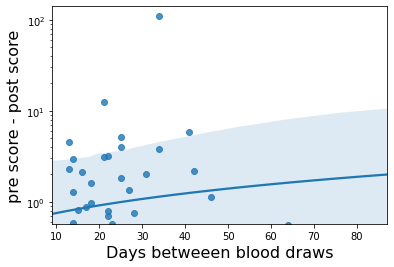

In [406]:
plt.figure()
days=[]
score_diffs=[]
for k,v in patient_dict.items():
    pre_score = float(inference_predictions.loc[inference_predictions["sample_id"]==v["pre"], "score"].values)
    post_score = float(inference_predictions.loc[inference_predictions["sample_id"]==v["post"], "score"].values)
    score_diffs.append(pre_score - post_score)
    days.append(intervals[v["post"]])

import statsmodels.api as sm

model = sm.OLS(score_diffs,days)
results = model.fit()
print(results.summary())

sns.regplot(x=days, y=np.array(score_diffs)+0.001)
plt.xlabel("Days betweeen blood draws", size=16)
plt.ylabel("pre score - post score", size=16)
plt.yscale("log")

There is no significant relationship between days between blood draws and the differenece in pre/post sample scores. 

In [351]:
# perform unsupervised clustering of samples to see if pre and post samples cluster together.
pre_post_hmf = mat_pre_post.x[...,3,0]/mat_pre_post.x[...,3,1]

In [353]:
np.isnan(mat_pre_post.x).sum()

0

Text(0, 0.5, 'PC4 (2.3%)')

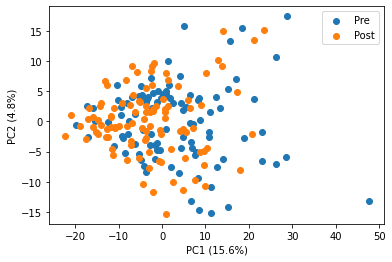

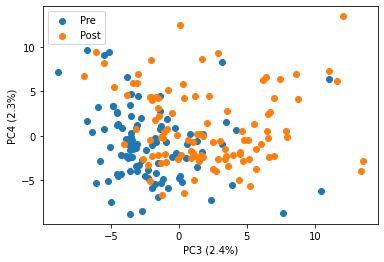

In [356]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
scaled_data = sc.fit_transform(pre_post_hmf)
scaled_data = np.log(scaled_data + 1)
#scaled_data = pre_post_hmf
scaled_data = np.nan_to_num(scaled_data, nan=0.0)
pca = PCA(n_components=5)
pca_coords = pca.fit_transform(scaled_data)

keep_pre = [x.raw_sample_metadata["lims_sample"]["blood_draw_relative_to_tx"]=="Pre-Colonoscopy" for x in mat_pre_post.sample_metadata]
pre_pca = pca_coords[keep_pre]
plt.scatter(x=pre_pca[:,0], y=pre_pca[:,1], label="Pre")

keep_post = [x.raw_sample_metadata["lims_sample"]["blood_draw_relative_to_tx"]=="Post-Colonoscopy" for x in mat_pre_post.sample_metadata]
post_pca = pca_coords[keep_post]
plt.scatter(x=post_pca[:,0], y=post_pca[:,1], label="Post")

plt.legend()
plt.xlabel(f"PC1 ({round(pca.explained_variance_ratio_[0]*100,1)}%)")
plt.ylabel(f"PC2 ({round(pca.explained_variance_ratio_[1]*100,1)}%)")

plt.figure()
plt.scatter(x=pre_pca[:,2], y=pre_pca[:,3], label="Pre")
plt.scatter(x=post_pca[:,2], y=post_pca[:,3], label="Post")
plt.legend()
plt.xlabel(f"PC3 ({round(pca.explained_variance_ratio_[2]*100,1)}%)")
plt.ylabel(f"PC4 ({round(pca.explained_variance_ratio_[3]*100,1)}%)")


There is some evidence of weak clustering of pre vs post samples along PC3 which only explains 2.4% of the variance in methylaion levels. 

## Conclusion
Colonoscopy has little impact on methylation levels or HMFC model scores. There was no case where pre colonoscopy scores differed significantly from post colonoscopy scores. Clustering analysis does not strongly indicate differences between the two groups.